<a href="https://colab.research.google.com/github/parthjindl/DM-Project/blob/main/Copy_of_Copy_of_iocl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **IOCL**

**Data Loading**

In [313]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [314]:
import pandas as pd
from collections import Counter
data = pd.read_csv("/content/drive/MyDrive/IOCreviews5000.csv")

In [315]:
data.shape

(5000, 36)

In [316]:
def f(s):
  if s=="Haryana" :
    return 1 
  elif s=="Madhya Pradesh" :
    return 2
  elif s=="Manipur" :
    return 3
  elif s=="Telangana" :
    return 4
  elif s=="Bihar" :
    return 5
  elif s=="Assam" :
    return 6
  elif s=="Punjab" :
    return 7
  else :
    return 8

In [317]:
def fix (s):
  if float(s) >= 3.9:
    return 1
  else:
    return 0


In [318]:
data["State"] = data.state.apply(f)

In [319]:
data["Rating"] = data.Rating.apply(fix)

In [320]:
data.shape

(5000, 37)

In [321]:
!pip install pandasql
from pandasql import sqldf
q1 = """
         select 'RO Code', 'PIN Code','State', 'Rating', 'Review'
         
"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [322]:
data.shape

(5000, 37)

In [323]:
#pysqldf = lambda q: sqldf(q, globals())
#data = pysqldf(q1)

In [324]:
data.shape

(5000, 37)

In [325]:
## Counter(clean["editorsSelection"])

** *Text Cleaning**

> Indented block



In [326]:
!pip install nltk
import nltk
nltk.download("all")
from nltk import sent_tokenize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

In [327]:
sentences = [] # each comment as a doc
for i in data["Review"]:
    s=sent_tokenize(i)
    sentences.append(s)
sentences[0] 

['  A 100% pure oil filling pump']

In [328]:
# tokenization
from nltk.tokenize import word_tokenize
token_list= []
for i in sentences: # i is comment level
    for j in i:
      tokens = word_tokenize(j)
      words = [word for word in tokens if word.isalpha()]
      words = [word.lower() for word in words]
      token_list.append(words)

In [329]:
# lemmatization
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet 
lemmatizer = WordNetLemmatizer() 
def pos_tagger(nltk_tag): 
    if nltk_tag.startswith('J'): 
        return wordnet.ADJ 
    elif nltk_tag.startswith('V'): 
        return wordnet.VERB 
    elif nltk_tag.startswith('N'): 
        return wordnet.NOUN 
    elif nltk_tag.startswith('R'): 
        return wordnet.ADV 
    else:           
        return None
lemma_list = []
for i in token_list:
  pos_tagged = nltk.pos_tag(i)
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  lemma = [] 
  for word, tag in wordnet_tagged:
    if word == "i":
      continue
    if tag is None: 
      # if there is no available tag, append the token as is 
      lemma.append(word) 
    else:         
      # else use the tag to lemmatize the token 
      lemma.append(lemmatizer.lemmatize(word, tag))
  lemma_list.append(lemma)

**Aspect Extraction**

In [330]:
bi = []
for item in lemma_list:
  grams = [item[i:i+2] for i in range(len(item)-2+1)]
  bigrams = [' '.join(j) for j in grams]
  bi.append(bigrams)

In [331]:
bi_v = [bigram for i in bi for bigram in i]
uni_v = [unigram for i in lemma_list for unigram in i]

In [332]:
counter_bi = Counter(bi_v)

In [333]:
from nltk.corpus import stopwords

In [334]:
# filter before computing for less noise
for i in list(counter_bi.keys()):
  if i.split()[0] in stopwords.words('english'):
    if i.split()[1] in stopwords.words('english'):
      counter_bi.pop(i)

In [335]:
for i in list(counter_bi.keys()):
  w,t = nltk.pos_tag(i.split())[0]
  w1,t1 = nltk.pos_tag(i.split())[1]
  if t[0] != "N":
    if t1[0] != "N":
      counter_bi.pop(i)

In [336]:
import math
def pmi_index(bigram):
  a, b = bigram.split()
  new = []
  for i in bi_v:
    if i != bigram:
      for wor in i.split():
        new.append(wor)
    else:
      new.append(i)
  counter_new = Counter(new)
  if counter_new[a] == 0 or counter_new[b] == 0:
    pmi = "dependent"
  else:
    pmi = math.log(counter_new[bigram]/((counter_new[a]-counter_new[bigram])*(counter_new[b]-counter_new[bigram])/(len(new)-2*counter_new[bigram])))
  return pmi

In [337]:
counter_b = counter_bi.most_common(100)

In [338]:
bi_gram_list = [k for (k,v) in counter_b]

In [339]:
frequency = [v for (k,v) in counter_b]

In [340]:

from cmath import sqrt

In [341]:
pmi = [pmi_index(k) for (k,v) in counter_b]

In [342]:
fre_df = pd.DataFrame({"bigram":bi_gram_list, "pmi":pmi, "frequency": frequency})

In [343]:
fre_most = fre_df.sort_values(by="pmi", ascending=False).head(50)
fre_most

,bigram,pmi,frequency
57,drinking water,8.817703,50
19,indian oil,7.469018,97
2,all type,5.721639,220
33,credit card,5.315732,70
78,digital payment,5.169693,43
94,try to,5.045104,35
49,kind of,5.014486,59
5,type of,4.982338,196
58,debit card,4.927829,50
64,online payment,4.906751,48


In [344]:
select = fre_most.drop([60,51,0,43])
select_bi = select["bigram"] # bigrams selected

In [345]:
len(select_bi)

46

In [346]:
from collections import defaultdict  
bi_dict = defaultdict(list)
for bi in select_bi:
  f,s = bi.split()
  bi_dict[f].append(s)

In [347]:
sent_c = []
for sent in lemma_list: 
  if len(sent) > 1:
    sent_list = []
    for i in range(len(sent)-1):
      if sent[i] in list(bi_dict.keys()):
        if sent[i+1] in bi_dict[sent[i]]:
          bi = sent[i] + " " + sent[i+1]
          sent_list.append(bi)
        else:
          if sent[i] not in stopwords.words('english'):
            sent_list.append(sent[i])  
      else:
        if sent[i] not in stopwords.words('english'):
          sent_list.append(sent[i]) 
    sent_c.append(sent_list)
  elif len(sent) == 1:
    if sent[0] not in stopwords.words('english'):
      sent_c.append(sent)
    else:
      sent_c.append([])
  else:
    sent_c.append([])

In [348]:
sent1 = [] # comment level
for c in sentences:
  ll = []
  for s in c:
    tokens = word_tokenize(s)
    words = [word for word in tokens if word.isalpha()]
    words = [word.lower() for word in words]
    words = [word for word in words if word != 'i']
    ll.append(words)
  sent1.append(ll)

In [349]:
num_com = len(sentences)

In [350]:
com_sent = [] # basic list is sentence
count = 0
for i in range(num_com):
  end = count + len(sent1[i])
  cc = sent_c[count:end]
  com_sent.append(cc)
  count = end

In [351]:
comment = [] # basic list is comment
for com in com_sent:
  c = []
  for sent in com:
    for wor in sent:
      c.append(wor)
  comment.append(c)

In [352]:
noun = []
for com in comment:
  c = []
  for wor in com:
    if wor in select_bi:
      c.append(wor)
    else:
      w, t = nltk.pos_tag([wor])[0]
      if t[0] == "N":
        c.append(wor)
  noun.append(c)

In [353]:
words = [wor for c in noun for wor in c]

In [354]:
v_n = [n for n,c in Counter(words).most_common(500)]

In [355]:
!pip install sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
df = pd.DataFrame({"text":comment})
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x]))
vectorizer = TfidfVectorizer(vocabulary=v_n, ngram_range=(1,2))
TF_IDF = vectorizer.fit_transform(df['text'].values)
TF_IDF_array = TF_IDF.toarray()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [356]:
import numpy as np
sum = np.sum(TF_IDF_array,axis=0).tolist()

In [357]:
rank = pd.DataFrame({"feature":vectorizer.get_feature_names(),"index": sum}).sort_values("index", ascending=False)
rank.head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,index
6,facility,323.717234
3,air,320.141673
0,petrol,299.598209
2,service,276.500707
1,pump,224.599514
4,fuel,182.014840
11,payment,178.794337
12,staff,175.117768
5,fill,169.992586
8,station,167.768161


In [358]:
aspects = rank.head(20)["feature"]

In [359]:
aspects

6          facility
3               air
0            petrol
2           service
1              pump
4              fuel
11          payment
12            staff
5              fill
8           station
10             card
7              time
17            place
15           accept
119            type
9      all facility
22             work
13          quality
14              oil
18           diesel
Name: feature, dtype: object

**Aspect Categorization**

In [360]:
!pip install gensim
import gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [361]:
from gensim.models import Word2Vec

In [362]:
www = [word for item in sent_c for word in item]

In [363]:
len(Counter(www).keys())

3899

In [364]:
def skip(sent, n=3, s=2):
  k_grams = []
  for i in range(len(sent)):
    for z in range(s):
      seq = [sent[i]] + sent[i+z+1:i+z+n]
      if len(seq) == n and seq not in k_grams:
        k_grams.append(list(seq))
  return k_grams  

In [365]:
sent_c1 = [sent for sent in sent_c if sent != []]

In [366]:
sequences = []
for i in sent_c1:
  l = skip(i)
  sequences.append(l)

In [367]:
sequences = [sent for sent in sequences if sent != []]
seq = [s for sent in sequences for s in sent]

In [368]:
seq[:10]

[['pure', 'oil', 'fill'],
 ['quantity', 'quality', 'fuel'],
 ['quantity', 'fuel', 'heavy'],
 ['quality', 'fuel', 'heavy'],
 ['quality', 'heavy', 'light'],
 ['fuel', 'heavy', 'light'],
 ['fuel', 'light', 'vehicle'],
 ['heavy', 'light', 'vehicle'],
 ['heavy', 'vehicle', 'good'],
 ['light', 'vehicle', 'good']]

In [369]:
model = Word2Vec(seq, min_count=50)

In [370]:
word = 'staff'
model.wv.most_similar(positive=word)

[('staff be', 0.9933886528015137),
 ('friendly', 0.9923185110092163),
 ('bad', 0.9920773506164551),
 ('customer', 0.992051899433136),
 ('behaviour', 0.9918813705444336),
 ('behave', 0.9905108213424683),
 ('all staff', 0.9901160001754761),
 ('little', 0.9887937307357788),
 ('experience', 0.9887844324111938),
 ('bit', 0.9879568815231323)]

In [371]:
aspect_c = defaultdict(list)
for i in aspects:
  similar = model.wv.most_similar(positive=i)
  for w, s in similar:
    aspect_c[i].append(w)

In [372]:
aspect_c.keys()

dict_keys(['facility', 'air', 'petrol', 'service', 'pump', 'fuel', 'payment', 'staff', 'fill', 'station', 'card', 'time', 'place', 'accept', 'type', 'all facility', 'work', 'quality', 'oil', 'diesel'])

In [373]:
d = ['facility', 'air', 'petrol', 'service', 'pump']
for i in d:
  aspect_c.pop(i)
category = dict(aspect_c)

In [374]:
for (a, s) in category.items():
  for wor in s:
    w,t = nltk.pos_tag([wor])[0]
    if t[0] != 'N':
      category[a].remove(wor)

In [375]:
category

{'fuel': ['product',
  'petroleum',
  'india',
  'measurement',
  'heavy',
  'ka',
  'stand',
  'fast'],
 'payment': ['accept',
  'payment accept',
  'part',
  'mode',
  'upi',
  'cash',
  'accepts',
  'card payment',
  'debit card'],
 'staff': ['staff be',
  'bad',
  'customer',
  'behaviour',
  'behave',
  'all staff',
  'experience',
  'bit'],
 'fill': ['tank', 'wait', 'put', 'person', 'u', 'refuel', 'refill', 'people'],
 'station': ['pump',
  'road',
  'petrol',
  'place',
  'big',
  'busy',
  'this place',
  'fuel station'],
 'card': ['part',
  'debit card',
  'cash',
  'credit card',
  'accept',
  'pay',
  'upi',
  'payment',
  'card accept',
  'wallet'],
 'time': ['open',
  'people',
  'go',
  'visit',
  'queue',
  'wait',
  'all time',
  'crowd'],
 'place': ['visit',
  'this place',
  'road',
  'location',
  'busy',
  'people',
  'long'],
 'accept': ['payment',
  'payment accept',
  'upi',
  'part',
  'mode',
  'accepts',
  'cash',
  'card accept',
  'card payment'],
 'type': [

In [376]:
category ={'accept': ['payment',
  'upi',
  'payment accept',
  'card',
  'cash',
  'card accept'],
 'all facility': ['facility available',
  'facility',
  'toilet',
  'include',
  'washroom',
  'water',
  'drinking water',
  'clean',
  'drink'],
 'card': ['part',
  'cash',
  'debit card',
  'credit card',
  'accept',
  'upi',
  'payment',
  'accepts',
  'wallet'],
 'diesel': ['all time',
  'pure',
  'petrol diesel',
  'petrol',
  'sell',
  'accurate',
  'gas',
  'premium'],
 'fill': ['tank', 'put', 'person', 'wait', 'bike', 'air fill', 'try to', 'u'],
 'fuel': ['product',
  'petroleum',
  'pure',
  'supply',
  'accurate',
  'sell',
  'measurement',
  'suggest',
  'issue'],
 'oil': ['corporation',
  'engine',
  'petroleum',
  'outlet',
  'city',
  'use',
  'change',
  'indian oil',
  'reward'],
 'payment': ['accept',
  'payment accept',
  'upi',
  'part',
  'accepts',
  'mode',
  'cash',
  'card accept',
  'wallet'],
 'place': ['visit', 'this place', 'location', 'near', 'main', 'area'],
 'quality': ['quantity',
  'and quantity',
  'good quality',
  'accurate',
  'pure',
  'petrol',
  'product',
  'fuel',
  'diesel'],
 'staff': ['staff be',
  'all staff',
  'behave',
  'area',
  'behaviour',
  'customer',
  'location'],
 'station': ['pump',
  'road',
  'place',
  'good',
  'this place',
  'petrol',
  'location'],
 'time': ['go', 'queue', 'location', 'all time', 'crowd', 'lot', 'visit'],
 'type': ['method',
  'digital payment',
  'payment mode',
  'online payment',
  'payment option',
  'mobile',
  'option',
  'transaction',
  'card payment'],
 'work': ['machine',
  'person',
  'guy',
  'puncture',
  'tyre',
  'air fill',
  'put',
  'fill']}

In [377]:
for k in category.keys():
  category[k].append(k)

In [378]:
c_v = [wor for k,v in category.items() for wor in v]

In [379]:
cc = []
for com in com_sent:
  ccc = []
  for sent in com:
    ss = []
    for wor in sent:
      if wor not in c_v:
        ss.append(wor)
      else:
        for k in category.keys():
          if wor in category[k]:
            ss.append(k)
    ccc.append(ss)
  cc.append(ccc)

In [380]:
opinion_d = []
for com in cc:
  com_d = defaultdict(list)
  for s in com:
    for k in category.keys():
      if any(w in s for w in category[k]) is True:
        com_d[k].append(s)
  opinion_d.append(dict(com_d))

In [381]:
opinion_d

[{'diesel': [['diesel', 'fuel', 'quality', 'oil', 'fill', 'work']],
  'fill': [['diesel', 'fuel', 'quality', 'oil', 'fill', 'work']],
  'fuel': [['diesel', 'fuel', 'quality', 'oil', 'fill', 'work']],
  'oil': [['diesel', 'fuel', 'quality', 'oil', 'fill', 'work']],
  'quality': [['diesel', 'fuel', 'quality', 'oil', 'fill', 'work']],
  'work': [['diesel', 'fuel', 'quality', 'oil', 'fill', 'work']]},
 {},
 {'fuel': [['quality',
    'quality',
    'fuel',
    'quality',
    'heavy',
    'light',
    'vehicle',
    'station',
    'staff']],
  'quality': [['quality',
    'quality',
    'fuel',
    'quality',
    'heavy',
    'light',
    'vehicle',
    'station',
    'staff']],
  'staff': [['quality',
    'quality',
    'fuel',
    'quality',
    'heavy',
    'light',
    'vehicle',
    'station',
    'staff']],
  'station': [['quality',
    'quality',
    'fuel',
    'quality',
    'heavy',
    'light',
    'vehicle',
    'station',
    'staff']]},
 {'accept': [['quality',
    'fuel',
    '

In [382]:
opinion = pd.DataFrame({"opinion sentences": opinion_d, "recommendation": data["Review"] , "editor selection": data["Rating"]})

In [383]:
opinion.drop(opinion[opinion['opinion sentences'] == {}].index, inplace = True)

In [384]:
opinion

,opinion sentences,recommendation,editor selection
0,"{'diesel': [['diesel', 'fuel', 'quality', 'oil...",A 100% pure oil filling pump,1
2,"{'fuel': [['quality', 'quality', 'fuel', 'qual...",a quantity + quality of fuel for heavy and l...,1
3,"{'accept': [['quality', 'fuel', 'quality', 'at...",a quality for fuel and all atm cards accepte...,1
7,"{'all facility': [['service', 'all facility', ...",a service Clean toilets and very well dresse...,1
9,"{'fuel': [['fuel', 'quality', 'station', 'day'...",A 24×7 fuel pump A day long busy pump Locate...,1
...,...,...,...
4989,"{'station': [['always', 'available', 'station']]}",Always available with good services,0
4990,"{'all facility': [['always', 'available', 'rus...",Always available with out any Rush and the p...,1
4993,"{'time': [['always', 'available', 'day', 'time...",Always available only day time after 10 o cl...,1
4997,"{'accept': [['always', 'avoid', 'station', 'ur...",Always avoid this pump - if its urgent pay b...,0


**Sentiment Orientation**

In [385]:
def split_sentence(o_p, k):
  if k in o_p.keys():
    list_s = o_p[k]
  else:
    list_s = []
  return list_s

In [386]:
for k in category.keys():
  m = []
  for i in opinion['opinion sentences']:
    x = split_sentence(i, k)
    m.append(x)
  opinion[k] = m

In [387]:
# staff
staff = pd.DataFrame({"staff": opinion['staff']})
staff = staff[staff['staff'].apply(lambda x: len(x)) > 0]
staff_index = list(staff.index)

In [388]:
def word_list(l):
  ll = []
  for i in list(l):
    w = []
    for s in i:
      for word in s:
        w.append(word)
    ll.append(w)
  return ll

In [389]:
def get_v(list_p):
  v = [w for s in list_p for w in s]
  feature = [k for k, v in Counter(v).most_common() if v > 5]
  return feature

In [390]:
staff_list = word_list(staff["staff"])
feature1 = get_v(staff_list)
staff_list = pd.DataFrame({"staff":staff_list})
staff_list['staff'] = staff_list['staff'].apply(lambda x: ' '.join([word for word in x]))

In [391]:
vectorizer = TfidfVectorizer(vocabulary=feature1, ngram_range=(1,2))
TF_IDF1 = vectorizer.fit_transform(staff_list['staff'].values)
TF_IDF_array1 = TF_IDF1.toarray()

In [392]:
from sklearn.cluster import KMeans
kmeans1 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF1)

In [393]:
from sklearn.metrics import pairwise_distances_argmin_min
closest1, _ = pairwise_distances_argmin_min(kmeans1.cluster_centers_, TF_IDF1)

In [394]:
sentences[staff_index[closest1[0]]]  # positive

['  A good Petrol Pump to fill in for the residents nearby is playa and Airforce Area Good Service']

In [395]:
sentences[staff_index[closest1[1]]]  # negative

['  All staff Not good behaviour , and they not listen you']

In [396]:
label1 = kmeans1.labels_

In [397]:
opinion["senti1"] = np.zeros(len(opinion))
for i in range(len(label1)):
  if label1[i] == 0:
    opinion["senti1"][staff_index[i]] = -1
  if label1[i] == 1:
    opinion["senti1"][staff_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [398]:
# work
work = pd.DataFrame({"work": opinion['work']})
work = work[work['work'].apply(lambda x: len(x)) > 0]
work_index = list(work.index)

In [399]:
work_list = word_list(work["work"])
feature2 = get_v(work_list)
work_list = pd.DataFrame({"work":work_list})
work_list['work'] = work_list['work'].apply(lambda x: ' '.join([word for word in x]))

In [400]:
vectorizer2 = TfidfVectorizer(vocabulary=feature2, ngram_range=(1,2))
TF_IDF2 = vectorizer2.fit_transform(work_list['work'].values)
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF2)
closest2, _ = pairwise_distances_argmin_min(kmeans2.cluster_centers_, TF_IDF2)

In [401]:
sentences[work_index[closest2[0]]] # positive

['  A good & safe to fill fuel dismal & petrol both a retail outlet for all !']

In [402]:
sentences[work_index[closest2[1]]] # negative

['  Air filling and puncture fellow is unprofessional']

In [403]:
label2 = kmeans2.labels_
opinion["senti2"] = np.zeros(len(opinion))
for i in range(len(label2)):
  if label2[i] == 0:
    opinion["senti2"][work_index[i]] = -1
  if label2[i] == 1:
    opinion["senti2"][work_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [404]:
# station
station = pd.DataFrame({"station": opinion['station']})
station = station[station['station'].apply(lambda x: len(x)) > 0]
station_index = list(station.index)

In [405]:
station_list = word_list(station["station"])
feature3 = get_v(station_list)
station_list = pd.DataFrame({"station":station_list})
station_list['station'] = station_list['station'].apply(lambda x: ' '.join([word for word in x]))

In [406]:
vectorizer3 = TfidfVectorizer(vocabulary=feature3, ngram_range=(1,2))
TF_IDF3 = vectorizer3.fit_transform(station_list['station'].values)
kmeans3 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF3)
closest3, _ = pairwise_distances_argmin_min(kmeans3.cluster_centers_, TF_IDF3)

In [407]:
sentences[station_index[closest3[0]]] # negative

['  All facilities available , like i e Pump , Groceries , Service Station Good Staff Visiting this Petrol pump since 1998']

In [408]:
sentences[station_index[closest3[1]]] # positive

['  A good A site petrol pump']

In [409]:
label3 = kmeans3.labels_
opinion["senti3"] = np.zeros(len(opinion))
for i in range(len(label3)):
  if label3[i] == 0:
    opinion["senti3"][station_index[i]] = -1
  if label3[i] == 1:
    opinion["senti3"][station_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**Text Classification**

In [410]:
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [411]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score

In [412]:
y = opinion['editor selection']
X = opinion.iloc[:, 17:31]
X = X.drop(['work'], axis=1)
# X

In [413]:
opinion['editor selection'].value_counts()

1    2439
0    1567
Name: editor selection, dtype: int64

In [414]:
def isfloat(num):
    try:
        len(num)
        return False
    except ValueError:
        return True


In [415]:
def func(s):
  if type(s) == float:
    return s
  return 0.0

In [416]:
temp = pd.melt(X)
X
# X(['A'], axis=1)

,senti1,senti2,senti3
0,0.0,-1.0,0.0
2,-1.0,0.0,1.0
3,0.0,0.0,0.0
7,-1.0,0.0,0.0
9,-1.0,0.0,-1.0
...,...,...,...
4989,0.0,0.0,-1.0
4990,-1.0,0.0,-1.0
4993,0.0,0.0,0.0
4997,0.0,-1.0,-1.0


In [417]:
temp['value'] = temp.value.apply(func)
temp

,variable,value
0,senti1,0.0
1,senti1,-1.0
2,senti1,0.0
3,senti1,-1.0
4,senti1,-1.0
...,...,...
12013,senti3,-1.0
12014,senti3,-1.0
12015,senti3,0.0
12016,senti3,-1.0


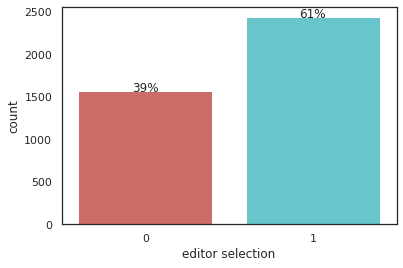

In [418]:
import seaborn as sns
sns.set(style="white")
graph = sns.countplot(x = opinion['editor selection'], data = opinion,palette="hls")
i = 0
for p in graph.patches:
  height = p.get_height()  
  graph.text(p.get_x()+p.get_width()/2., height + 0.1,
         '{0:.0%}'.format((opinion['editor selection'].value_counts()[i])/4006),ha="center")
  i += 1
plt.figure
plt.savefig('fig5.eps', bbox_inches='tight')


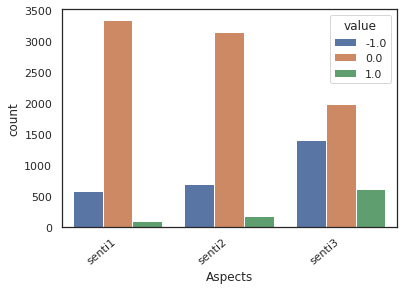

In [419]:
graph2 = sns.countplot(x="variable", hue="value", data=temp)
graph2.set_xticklabels(graph2.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Aspects')
plt.figure
plt.savefig('fig6.eps', bbox_inches='tight')


In [420]:
# oversample = ADASYN()
# print(X)
# print(y)
# X, y = oversample.fit_resample(X, y)

In [421]:
Counter(y)

Counter({1: 2439, 0: 1567})

In [534]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.9,random_state=11,stratify=y)

In [535]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)

In [536]:
forest1 = RandomForestClassifier(oob_score = True, n_jobs = -1)

In [537]:
clf1 = LogisticRegression(random_state=0)

In [538]:
scores1 = cross_val_score(forest1, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [539]:
scores2 = cross_val_score(clf1, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [540]:
from numpy import mean, std

In [541]:
print('Performce of Random Forest: %.3f' % (mean(scores1)))

Performce of Random Forest: 0.622


In [542]:
print('Performance of Logistic Regraression: %.3f' % (mean(scores2)))

Performance of Logistic Regraression: 0.605


In [543]:
y_test_pred1 = forest1.fit(X_train,y_train).predict(X_test)
y_test_pred2 = clf1.fit(X_train,y_train).predict(X_test)

In [544]:
print("Accuracy of test - Random Forest:",metrics.accuracy_score(y_test, y_test_pred1))
print("Accuracy of test - Logistic Regression:",metrics.accuracy_score(y_test, y_test_pred2))

Accuracy of test - Random Forest: 0.5926234054353855
Accuracy of test - Logistic Regression: 0.6070438158624515


In [545]:
target_names = ["0","1"]
print(classification_report(y_test, y_test_pred1, target_names=target_names))

              precision    recall  f1-score   support

           0       0.43      0.12      0.18      1411
           1       0.61      0.90      0.73      2195

    accuracy                           0.59      3606
   macro avg       0.52      0.51      0.46      3606
weighted avg       0.54      0.59      0.52      3606



In [546]:
print(classification_report(y_test, y_test_pred2, target_names=target_names))

              precision    recall  f1-score   support

           0       0.45      0.02      0.04      1411
           1       0.61      0.98      0.75      2195

    accuracy                           0.61      3606
   macro avg       0.53      0.50      0.40      3606
weighted avg       0.55      0.61      0.47      3606



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


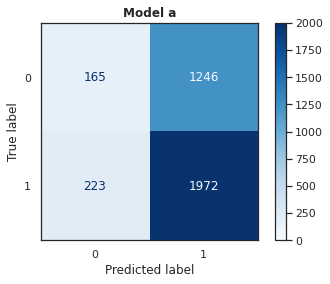

In [547]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
cm1 = plot_confusion_matrix(forest1, X_test, y_test, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
plt.title("Model a",fontweight="bold")
cm1.ax_.get_images()[0].set_clim(0, 2000)
plt.figure
plt.savefig('fig1.eps', bbox_inches='tight')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


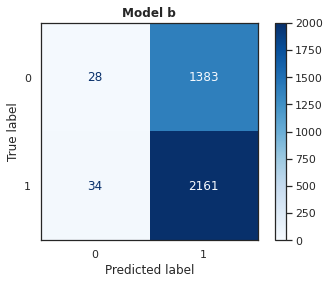

In [548]:
cm2 = plot_confusion_matrix(clf1, X_test, y_test, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
plt.title("Model b",fontweight="bold")
cm2.ax_.get_images()[0].set_clim(0, 2000)
plt.figure
plt.savefig('fig2.eps', bbox_inches='tight')


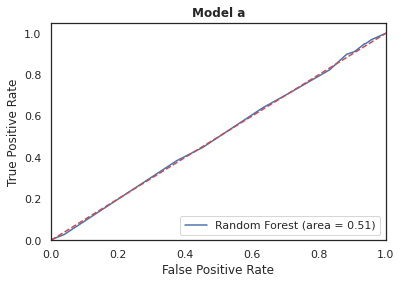

In [549]:
forest_roc_auc = roc_auc_score(y_test, forest1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, forest1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model a",fontweight="bold")
plt.legend(loc="lower right")
plt.figure
plt.savefig('fig7.eps', bbox_inches='tight')


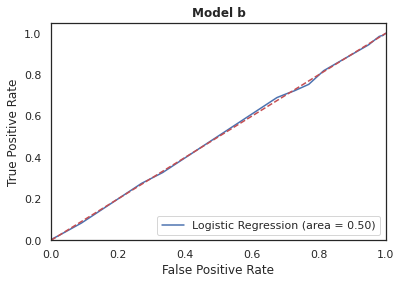

In [550]:
logit_roc_auc = roc_auc_score(y_test, clf1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model b",fontweight="bold")
plt.legend(loc="lower right")
plt.figure
plt.savefig('fig8.eps', bbox_inches='tight')


In [551]:
X_c = np.zeros([4006, 6])
X

,senti1,senti2,senti3
0,0.0,-1.0,0.0
2,-1.0,0.0,1.0
3,0.0,0.0,0.0
7,-1.0,0.0,0.0
9,-1.0,0.0,-1.0
...,...,...,...
4989,0.0,0.0,-1.0
4990,-1.0,0.0,-1.0
4993,0.0,0.0,0.0
4997,0.0,-1.0,-1.0


In [552]:
# dummy
# print(type(X))
temp=X.values.tolist()

for j in range(4006):
  for i in range(3):
    ii = 2*i
    # print(X[j,i])
    if temp[j][i] == 1:
      X_c[j][ii] = 1
    if temp[j][i] == -1:
      X_c[j][ii+1] = 1

In [553]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c,y,test_size=0.9,random_state=0,stratify=y)

In [554]:
forest2 = RandomForestClassifier(oob_score = True, n_jobs = -1)

In [555]:
clf2 = LogisticRegression(random_state=0)

In [556]:
scores3 = cross_val_score(forest2, X_train_c, y_train_c, scoring='accuracy', cv=cv, n_jobs=-1)

In [557]:
scores4 = cross_val_score(clf2, X_train_c, y_train_c, scoring='accuracy', cv=cv, n_jobs=-1)

In [558]:
print('Performce of Random Forest: %.3f' % (mean(scores3)))

Performce of Random Forest: 0.607


In [559]:
print('Performance of Logistic Regraression: %.3f' % (mean(scores4)))

Performance of Logistic Regraression: 0.607


In [560]:
y_test_pred3 = forest2.fit(X_train_c,y_train_c).predict(X_test_c)
y_test_pred4 = clf2.fit(X_train_c,y_train_c).predict(X_test_c)

In [561]:
print("Accuracy of test - Random Forest:",metrics.accuracy_score(y_test_c, y_test_pred3))
print("Accuracy of test - Logistic Regression:",metrics.accuracy_score(y_test_c, y_test_pred4))

Accuracy of test - Random Forest: 0.6045479755962285
Accuracy of test - Logistic Regression: 0.6048252911813644


In [562]:
print(classification_report(y_test_c, y_test_pred3, target_names=target_names))

              precision    recall  f1-score   support

           0       0.45      0.05      0.09      1411
           1       0.61      0.96      0.75      2195

    accuracy                           0.60      3606
   macro avg       0.53      0.51      0.42      3606
weighted avg       0.55      0.60      0.49      3606



In [563]:
print(classification_report(y_test_c, y_test_pred4, target_names=target_names))

              precision    recall  f1-score   support

           0       0.45      0.05      0.08      1411
           1       0.61      0.96      0.75      2195

    accuracy                           0.60      3606
   macro avg       0.53      0.51      0.42      3606
weighted avg       0.55      0.60      0.49      3606



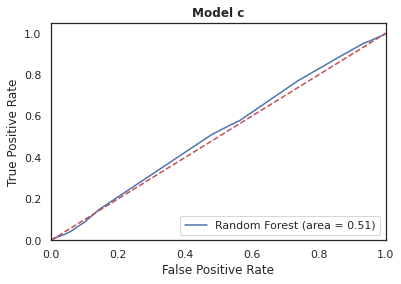

In [564]:
forest_roc_auc = roc_auc_score(y_test_c, forest2.predict(X_test_c))
fpr, tpr, thresholds = roc_curve(y_test_c, forest2.predict_proba(X_test_c)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model c",fontweight="bold")
plt.legend(loc="lower right")
plt.figure
plt.savefig('fig9.eps', bbox_inches='tight')
# files.download("fig9.eps")

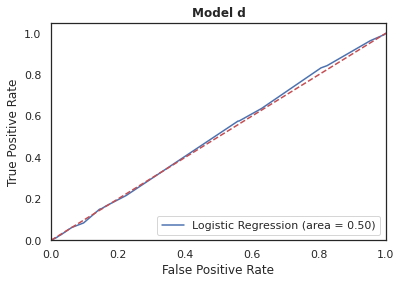

In [565]:
lr_roc_auc = roc_auc_score(y_test_c, clf2.predict(X_test_c))
fpr, tpr, thresholds = roc_curve(y_test_c, clf2.predict_proba(X_test_c)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("Model d",fontweight="bold")
plt.legend(loc="lower right")
plt.figure
plt.savefig('fig10.eps', bbox_inches='tight')
# files.download("fig10.eps")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


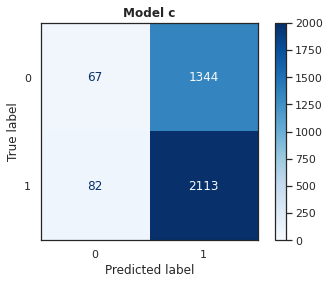

In [566]:
cm3 = plot_confusion_matrix(forest2, X_test_c, y_test_c, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
cm3.ax_.get_images()[0].set_clim(0, 2000)
plt.title("Model c",fontweight="bold")
plt.figure
plt.savefig('fig3.eps', bbox_inches='tight')
# files.download("fig3.eps")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


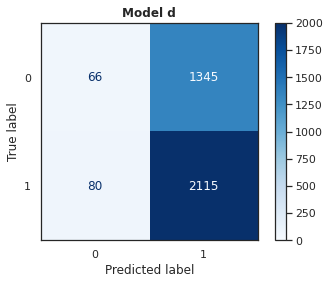

In [567]:
cm4 = plot_confusion_matrix(clf2, X_test_c, y_test_c, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
cm4.ax_.get_images()[0].set_clim(0, 2000)
plt.title("Model d",fontweight="bold")
plt.figure
plt.savefig('fig4.eps', bbox_inches='tight')
# files.download("fig4.eps")